In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, pairwise_distances
import matplotlib.pyplot as plt

sns.set()

In [2]:
def get_rate(matrix):
    tp = 0
    for i in range(matrix.shape[0]):
        tp = tp + matrix[i,i]
    rate = np.round(tp/matrix.sum(), 3)*100
    #print(f"{tp} digits correctly classified.")
    #print(f"Classifier performance rate: %{int(100*rate)}")
    return rate

class Network:
    def __init__(self, learning_rate, df):
        df_in = df.copy().iloc[:,:-1]
        df_in.insert(loc=0, column='bias', value=1)
        df_out = df.copy().iloc[:,-1]
        self.input = df_in.to_numpy()
        self.actual = df_out.to_numpy()
        self.weights = np.random.random((257,2))
        self.learning_rate = learning_rate
        self.targets = list(set(df_out))
        
    def train_network(self, iter_num):
        for num in range(iter_num):
            # All activated nodes as matrix z
            z = np.dot(self.input, self.weights)
            # y_predicted is the prediction
            y_predicted = np.argmax(z, axis=1)
            misclasssifiedIndexes = np.not_equal(y_predicted, self.actual)
            # iterate over inputs
            for j in range(self.input.shape[0]):
                if misclasssifiedIndexes[j]:
                    for i in range(len(self.targets)):
                        if i == self.targets.index(self.actual[j]):
                            self.weights[:,i] = self.weights[:,i] + self.learning_rate*self.input[j]
                        elif z[j, i] > z[j,self.targets.index(self.actual[j])]:
                            self.weights[:,i] = self.weights[:,i] - self.learning_rate*self.input[j]
                            
    def modified_training(self, iter_num):
        """
        We updated the learning algorithm with adding an error function. 
        The definition of the error is (d-y) desired - predicted.
        However it can take negative values depend on the value of desired and predicted. 
        Thats why we define the error as;
            Error = 1/2*(d-y)^2
        """
        for num in range(iter_num):
            # All activated nodes as matrix z
            z = np.dot(self.input, self.weights)
            # y_predicted is the prediction
            y_predicted = np.argmax(z, axis=1)            
            misclasssifiedIndexes = np.not_equal(y_predicted, self.actual)
            # iterate over inputs
            for j in range(self.input.shape[0]):
                error = 1/2*(self.actual[j] - y_predicted[j])**2                
                if misclasssifiedIndexes[j]:
                    for i in range(len(self.targets)):
                        if i == self.targets.index(self.actual[j]):
                            self.weights[:,i] = self.weights[:,i] + self.learning_rate*error*self.input[j]
                        elif z[j, i] > z[j,self.targets.index(self.actual[j])]:
                            self.weights[:,i] = self.weights[:,i] - self.learning_rate*error*self.input[j]
        
    def predict(self, tSet):
        f = tSet.copy().iloc[:, :-1]
        targets = list(set(tSet.copy().iloc[:,-1]))
        f.insert(loc=0, column='bias', value=1)
        result = np.argmax(np.dot(f.to_numpy(), self.weights), axis=1)
        for i, v in enumerate(result):
            if v == 0:
                result[i] = targets[0]
            else:
                result[i] = targets[1]
        return result

In [3]:
df_in = pd.read_csv("data/train_in.csv", header=None)
df_out = pd.read_csv("data/train_out.csv", header=None, names=['label'])
df = df_in.join(df_out)

In [4]:
import itertools
digits = np.arange(10)
pairs = dict()
for (d1, d2) in itertools.combinations(digits, r=2):
    pairs[(d1, d2)] = df[(df['label']==d1) | (df['label']==d2)]

In [5]:
pairs.keys()

dict_keys([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)])

According to Cover's Theorem:
<ol>
    <li> if the number of points in d-dimensional space is smaller than 2*d then they are <strong>almost always linearly separable</strong></li>
    <li> if the number of points in d-dimensional space is bigger than 2*d then they are <strong>almost always linearly non-separable</strong></li>
</ol>


In [6]:
def check_Seperability(pairs, dimension):
    result = dict()
    d2 = 2*dimension
    for pair, df in pairs.items():
        result[pair] = True if df.shape[0]<=d2 else False
        
    rt = pd.DataFrame.from_dict(result, orient='index').reset_index()
    rt.rename(columns={'index':'pairs', 0: "Seperability"}, inplace=True )
    
    return rt

In [7]:
sep = check_Seperability(pairs, 256)
sep.head()

,pairs,Seperability
0,"(0, 1)",False
1,"(0, 2)",False
2,"(0, 3)",True
3,"(0, 4)",True
4,"(0, 5)",True


In [8]:
sep[sep['Seperability']==False]

,pairs,Seperability
0,"(0, 1)",False
1,"(0, 2)",False


In [9]:
def get_performances_for_pairs(pairs):
    performances = {}
    confxs = {}
    for pair, df in pairs.items():
        net = Network(learning_rate=1, df=df)
        net.train_network(iter_num = 3000)
        pred = net.predict(df)
        confx = confusion_matrix(df.iloc[:,-1], pred)
        confxs[pair] = confx
        perf = get_rate(confx)
        performances[pair] = perf
    return performances, confxs

In [10]:
pers, confs = get_performances_for_pairs(pairs)

In [11]:
pers

{(0, 1): 100.0,
 (0, 2): 86.9,
 (0, 3): 88.0,
 (0, 4): 90.0,
 (0, 5): 89.4,
 (0, 6): 85.3,
 (0, 7): 86.6,
 (0, 8): 87.9,
 (0, 9): 88.9,
 (1, 2): 44.5,
 (1, 3): 34.2,
 (1, 4): 32.6,
 (1, 5): 77.10000000000001,
 (1, 6): 37.5,
 (1, 7): 86.8,
 (1, 8): 89.9,
 (1, 9): 34.4,
 (2, 3): 94.6,
 (2, 4): 92.30000000000001,
 (2, 5): 84.8,
 (2, 6): 95.8,
 (2, 7): 97.3,
 (2, 8): 95.39999999999999,
 (2, 9): 97.89999999999999,
 (3, 4): 99.2,
 (3, 5): 82.6,
 (3, 6): 97.89999999999999,
 (3, 7): 91.60000000000001,
 (3, 8): 93.5,
 (3, 9): 97.0,
 (4, 5): 88.6,
 (4, 6): 94.89999999999999,
 (4, 7): 88.9,
 (4, 8): 97.0,
 (4, 9): 89.8,
 (5, 6): 79.10000000000001,
 (5, 7): 80.7,
 (5, 8): 83.2,
 (5, 9): 83.6,
 (6, 7): 98.1,
 (6, 8): 98.3,
 (6, 9): 99.6,
 (7, 8): 93.5,
 (7, 9): 88.9,
 (8, 9): 98.6}

In [12]:
def createPlot(performances, name):
    fig, ax = plt.subplots(figsize=(20, 6))
    matrix = np.zeros((10,10), dtype=int)
    for (k1, k2), value in performances.items():
        matrix[k2,k1] = int(np.round(value))
    mask = np.zeros_like(matrix)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(matrix, cmap="Blues", mask=mask, annot=True, fmt='d', linewidths=.5, square=True)
    ax.set_xlabel('Digits')
    ax.set_ylabel('Digits')
    ax.set_title("Linearly Seperability of Digits' Pairs")
    fig.savefig(name)
    plt.show()

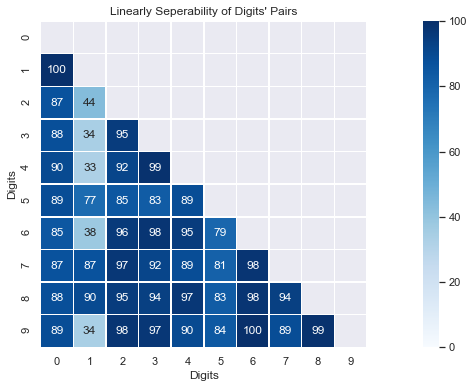

In [14]:
createPlot(pers, "./images/LinearlySeperability_TrainingSet3000.png")